In [56]:
import requests
from tqdm import tqdm
from requests.auth import HTTPBasicAuth
from pprint import pprint
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects

from PIL import Image
import urllib
import matplotlib.font_manager as fm
from highlight_text import fig_text

import matplotlib.pyplot as plt
#from mplsoccer import Pitch, VerticalPitch
import plotly.graph_objects as go
import plotly.express as px


ID_2019_20 = 185844
ID_2020_21 = 186353
ID_2021_22 = 187528
ID_2022_23 = 188160


username = 'qjpuw3t-yf3bvhgms-8d0gift-bm2fprvs4z'
token =  '7*.w$Ivko$FpRsbumn0gF(0Kc5yMAI'


Players, Teams

In [57]:
base_url = 'https://apirest.wyscout.com/v2{}'

competitions = [
    #516, #primavera
    #42976, #primavera 2
    524, #serie A
    #527, #serie B
    #520, #serie C
]

Serie_A = 524

available_seasons = [(Serie_A, ID_2022_23)]



players,teams = [],[]
players_season = {}
for season in available_seasons:
    

    api_url = base_url.format(f'/seasons/{season[1]}/players')

    response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
    if response.ok:
      player = response.json()['players']
      players+=player
    for p in player:
        players_season[p['wyId']] = season
    
    
    
    api_url = base_url.format(f'/seasons/{season[1]}/teams')

    response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
    if response.ok:
        team = response.json()['teams']
        teams+=team
    

events

In [58]:
events = []
sb_events = []
matches = []

def second_ball(events):
    second_balls = []

    for i,event in enumerate(events):
        
        if event['subEventName'] == "Air duel":
            
            next_events = events[i+1:i+3]
            
            passes_next = [x for x in next_events if x["eventName"] == "Pass"]
            
            if len(passes_next) == 0:
                continue
            else:
                my_pass = passes_next[0]
                # Tag 1801 : Accurate
                if {'id': 1801} in my_pass['tags']:
                    #second ball detected
                    doc = {
                        'playerId' : my_pass['playerId'],
                        'matchId' : my_pass['matchId'],
                        'teamId' :  my_pass['teamId'],
                        'eventSec' : my_pass['eventSec'],
                        'positions' : my_pass['positions'],
                        'eventSec' : event['eventSec'],
                        'matchPeriod' : my_pass['matchPeriod'] ,
                        'eventName' : "Second Ball",
                        'subEventName' : "Second Ball",
                        'eventId' : 9999,
                        'subEventId': 0
                    }
                    second_balls.append(doc)
        

    return second_balls

def air_duel(events):
    aird = []
    
    for i,event in enumerate(events):
        
        if event['subEventName'] == "Air duel":
            
            doc = {
                    'playerId' : event['playerId'],
                    'matchId' : event['matchId'],
                    'teamId' :  event['teamId'],
                    'eventSec' : event['eventSec'],
                    'positions' : event['positions'],
                    'eventSec' : event['eventSec'],
                    'matchPeriod' : event['matchPeriod'] ,
                    'eventName' : "Duel",
                    'subEventName' : "Air duel",
                    'eventId' : 1,
                    'subEventId': 10
                    }
            aird.append(doc)
        

    return aird

for season in available_seasons:

    api_url = base_url.format(f'/seasons/{season[1]}/matches')

    response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
    if response.ok:
      season_matches = response.json()['matches']

    
    for m in tqdm(season_matches):
        api_url = base_url.format('/matches/%s/events'%(m['matchId']))
        response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
        if response.ok:
            match_events = response.json()['events']
            second_balls_match = second_ball(match_events)
            aird = air_duel(match_events)
            
            events += match_events
            events += second_balls_match
            sb_events += aird
            sb_events += second_balls_match
        
        
        api_url = base_url.format('/matches/%s'%(m['matchId']))
        response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
        if response.ok:
            matches.append( response.json())
        
player_name = {}
for p in players:
  player_name[p['wyId']] = [p['shortName'], p['role']['code3']]

team_name = {}
for t in teams:
  team_name[t['wyId']] = t['name']

match_name = {}
for m in matches:
  match_name[m['wyId']] = m['label']

100%|██████████| 40/40 [00:54<00:00,  1.37s/it]


In [59]:
sb_loc = []
sb_list = sb_events

for i,ev in enumerate(sb_list):
  doc1 = {}
  doc1['player'] = player_name[ev['playerId']][0].encode().decode('unicode_escape') if ev['playerId'] in player_name.keys() else ev['playerId']
  doc1['role'] = player_name[ev['playerId']][1]
  doc1['match'] = match_name[ev['matchId']]
  doc1['team'] = team_name[ev['teamId']]
  doc1['eventName'] = ev['eventName']
  doc1['subEventName'] = ev['subEventName']
  doc1['eventId'] = ev['eventId']
  doc1['subEventId'] = ev['subEventId']
  doc1['matchPeriod'] = ev['matchPeriod']
  doc1['eventSec'] = ev['eventSec']
  doc1['x'] = ev['positions'][0]['x']
  doc1['y'] = ev['positions'][0]['y']
  sb_loc.append(doc1)

sb = pd.DataFrame(sb_loc)

In [60]:
import json
json.dump(sb_loc,  open("./data/sb_full_events_serieA_2022_2123_4.json","w"))

code below only to shorten analysis TIME

In [1]:
"""
#### Load diretcly JSON files
import json

# Opening stored JSON file: Wyscout API
t = open('../src/teams_serieA_2021_2122.json')
m = open('../src/matches_serieA_2021_2122.json')
sb = open('../src/sb_full_events_serieA_2021_2122.json')

# returns JSON object as 
# a dictionary
teams = json.load(t)
matches = json.load(m)
sb = json.load(sb)
"""

"\n#### Load diretcly JSON files\nimport json\n\n# Opening stored JSON file: Wyscout API\nt = open('../src/teams_serieA_2021_2122.json')\nm = open('../src/matches_serieA_2021_2122.json')\nsb = open('../src/sb_full_events_serieA_2021_2122.json')\n\n# returns JSON object as \n# a dictionary\nteams = json.load(t)\nmatches = json.load(m)\nsb = json.load(sb)\n"

========================

In [61]:
sb_df_full = pd.DataFrame(sb)
sb_df = sb_df_full[sb_df_full.role != "GKP"]

In [62]:
matches_df = pd.DataFrame(matches)
matches_2223 = matches_df[matches_df.seasonId==ID_2022_23]

In [63]:
sb_2223 = matches_2223.merge(sb_df, how="left", right_on="match", left_on="label")
sb_2223.drop(["wyId", "label", "date", "status", "duration", "winner", "competitionId", "seasonId", "roundId", "gameweek", "teamsData", "venue", "referees", "hasDataAvailable"], axis=1, inplace=True)

In [64]:
sb_2223.drop_duplicates(inplace=True)
sb_2223.reset_index(drop=True, inplace=True)

In [65]:
sb_2223_event = sb_2223[sb_2223.eventName == "Second Ball"]
sb_2223_duel = sb_2223[sb_2223.eventName == "Duel"]

In [66]:
sb_2223_by_team = sb_2223_event.groupby('team').count()['eventId']
sb_2223_by_team = sb_2223_by_team.sort_values(ascending=False)
sb_2223_by_team_duel = sb_2223_duel.groupby('team').count()['eventId']
sb_2223_by_team_duel = sb_2223_by_team.sort_values(ascending=False)

Create DF copies for the following preprocessing

In [67]:
sb_2223_copy = sb_2223.copy()

# 2022-23 Season chart

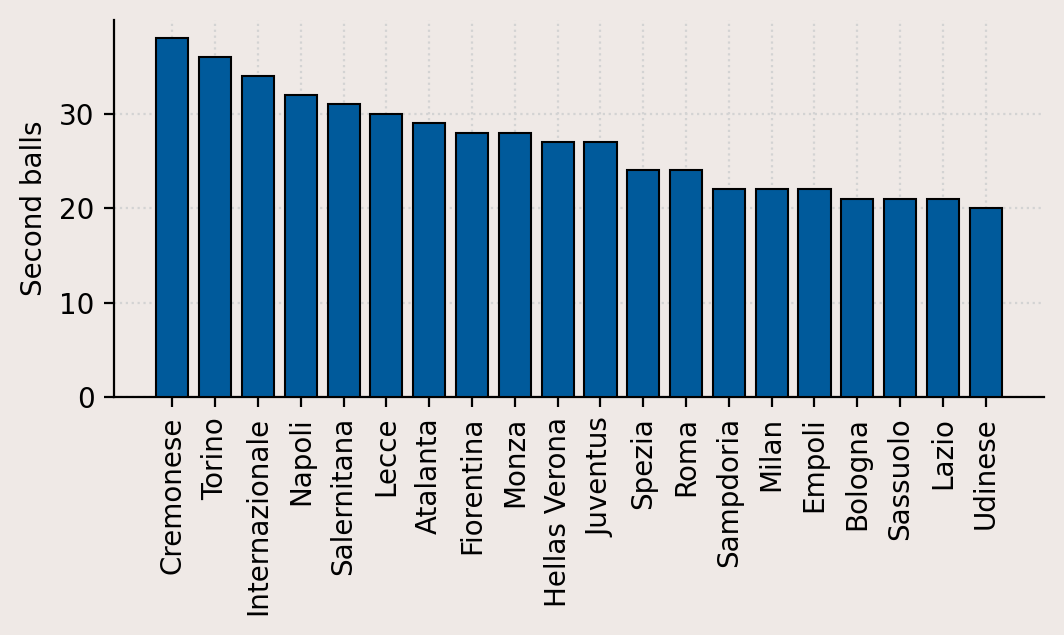

In [68]:
X_2223=sb_2223_by_team.index
height_2223 = sb_2223_by_team

fig = plt.figure(figsize=(6, 2.5), dpi = 200, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")

# Add spines
ax.spines["top"].set(visible = False)
ax.spines["right"].set(visible = False)

# Add grid and axis labels
ax.grid(True, color = "lightgrey", ls = ":")
ax.set_ylabel("Second balls")

ax.bar(
	X_2223, 
    height_2223, 
    ec = "black", 
    lw = .75, 
    color = "#005a9b", 
    zorder = 3, 
    width = 0.75
)

# Adjust ticks
ax.tick_params(axis = "x", rotation = 90)

### Let's split HOME/AWAY and Offensive/Defensive Second Ball to build a stacked bar chart

In [70]:
def DFpreprocessing (sb):
  sb_int = sb.copy()
  sb_int = sb_int[sb_int['eventName']=="Second Ball"]
  sb_int[['matchSimple', 'finalResult']] = sb_int['match'].str.split(',',1,expand=True)
  sb_int.drop(['match'], axis=1, inplace=True)
  sb_int.rename(columns={'matchSimple':'match'}, inplace=True)
  sb_int[['home', 'away']] = sb_int['match'].str.split(' - ',1,expand=True)
  sb_int['homeC'] =  np.where(sb_int['team']==sb_int['home'], 1, 0)
  sb_int['awayC'] =  np.where(sb_int['team']==sb_int['away'], 1, 0)
  sb_int['OH'] =  np.where(sb_int['x']>=50, 1, 0)
  sb_int['DH'] =  np.where(sb_int['x']<50, 1, 0)
  sb_int  = sb_int.groupby(["team"])['homeC', 'awayC', 'OH', 'DH'].sum().reset_index()
  sb_int['total'] = sb_int['homeC'] + sb_int['awayC']
  sb_int.sort_values(by='total', ascending=False, inplace=True)
  sb_int.reset_index(drop=True, inplace=True)
  sb_int.rename(columns={'homeC':'second balls home', 'awayC':'second balls away', 'total': 'total second balls', 'OH':'Offensive', 'DH': 'Defensive'}, inplace=True)
  sort_order = sb_int["team"].to_list()
  sb_int = sb_int.set_index("team")
  sb_int = sb_int.loc[sort_order]
  sb_int.reset_index(inplace = True)
  return sb_int, sort_order

In [71]:
def DFpreprocessingPRO (sb):
  sb_int = sb.copy()
  sb_int[['matchSimple', 'finalResult']] = sb_int['match'].str.split(',',1,expand=True)
  sb_int.drop(['match'], axis=1, inplace=True)
  sb_int.rename(columns={'matchSimple':'match'}, inplace=True)
  #sb_int[['home', 'away']] = sb_int['match'].str.split(' - ',1,expand=True)
  #sb_int['SB homeC'] =  np.where(sb_int['team']==sb_int['home'], 1, 0)
  #sb_int['SB awayC'] =  np.where(sb_int['team']==sb_int['away'], 1, 0)
  #sb_int['SB OH'] =  np.where(sb_int['x']>=50, 1, 0)
  #sb_int['SB DH'] =  np.where(sb_int['x']<50, 1, 0)
  sb_int['Duel'] = np.where(sb_int['eventName']=="Duel", 1, 0)
  sb_int['Second Ball'] = np.where(sb_int['eventName']=="Second Ball", 1, 0)
  sb_int  = sb_int.groupby(["team"])[['Duel', 'Second Ball']].sum().reset_index()
  #sb_int['total'] = sb_int['homeC'] + sb_int['awayC']
  sb_int.sort_values(by='Second Ball', ascending=False, inplace=True)
  sb_int.reset_index(drop=True, inplace=True)
  #sb_int.rename(columns={'homeC':'second balls home', 'awayC':'second balls away', 'total': 'total second balls', 'OH':'Offensive', 'DH': 'Defensive'}, inplace=True)
  sort_order = sb_int["team"].to_list()
  sb_int = sb_int.set_index("team")
  sb_int = sb_int.loc[sort_order]
  sb_int.reset_index(inplace = True)
  return sb_int, sort_order

In [73]:
sb_2223_per_team_venue, sort_order = DFpreprocessing(sb_2223)

C:\Users\fgron\AppData\Local\Temp\ipykernel_30472\2302468572.py:12: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [74]:
#Preprocessing Home/Away
height_h = (
    sb_2223_per_team_venue["second balls home"]
    .reset_index(drop = True)
)

height_a = (
    sb_2223_per_team_venue["second balls away"]
    .reset_index(drop = True)
)

# We'll annotate the x-axis differently.
X = np.arange(len(height_h))

In [75]:
#Preprocessing Offensive/Defensive
height_o = (
    sb_2223_per_team_venue["Offensive"]
    .reset_index(drop = True)
)

height_d = (
    sb_2223_per_team_venue["Defensive"]
    .reset_index(drop = True)
)

# We'll annotate the x-axis differently.
X = np.arange(len(height_o))

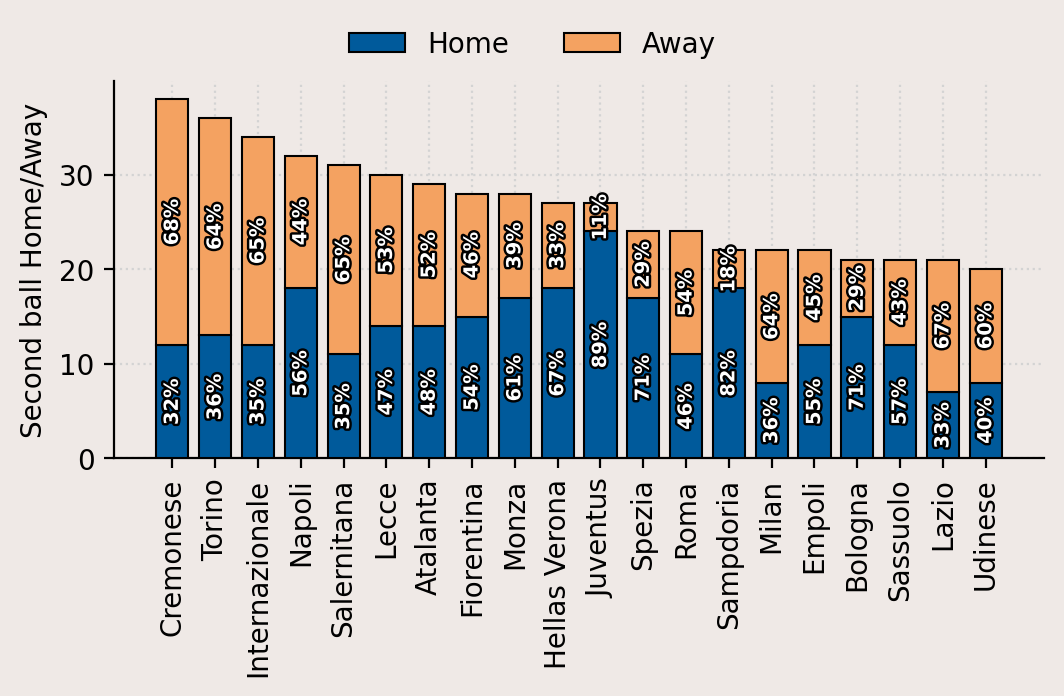

In [76]:
fig = plt.figure(figsize=(6, 2.5), dpi = 200, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")

# Add spines
ax.spines["top"].set(visible = False)
ax.spines["right"].set(visible = False)

# Add grid and axis labels
ax.grid(True, color = "lightgrey", ls = ":")
ax.set_ylabel("Second ball Home/Away")

# Home SB
ax.bar(
    X, 
    height_h, 
    ec = "black", 
    lw = .75, 
    color = "#005a9b", 
    zorder = 3, 
    width = 0.75,
    label = "Home"
)

# Away SB
ax.bar(
    X, 
    height_a,
    bottom = height_h, # This creates the stacked chart 
    ec = "black", 
    lw = .75, 
    color = "#f4a261", 
    zorder = 3, 
    width = 0.75,
    label = "Away"
)

ax.legend(
    ncol = 2, 
    loc = "upper center", 
    bbox_to_anchor = (0.45, 1.2),
    frameon = False
)

# Annotate the bar chart
aux_counter = 0
for y_h, y_a in zip(height_h, height_a):
    # annotate percentage of fouls in the center of the bar
    home_text = ax.annotate(
        xy = (aux_counter, y_h/2),
        text = f"{y_h/(y_h + y_a):.0%}", # F-strings are cool :)
        size = 7,
        ha = "center",
        va = "center",
        weight = "bold",
        color = "white",
        rotation = 90
    )

    away_text = ax.annotate(
        xy = (aux_counter, y_h + y_a/2), # Notice the sum of the bottom data.
        text = f"{y_a/(y_h + y_a):.0%}",
        size = 7,
        ha = "center",
        va = "center",
        weight = "bold",
        color = "white",
        rotation = 90
    )

    home_text.set_path_effects(
        [path_effects.Stroke(linewidth=1.75, foreground="black"), path_effects.Normal()]
    )

    away_text.set_path_effects(
        [path_effects.Stroke(linewidth=1.75, foreground="black"), path_effects.Normal()]
    )

    aux_counter += 1


# Adjust ticks
xticks_ = ax.xaxis.set_ticks(
    ticks = X,
    labels = sort_order,
    rotation = 90
)


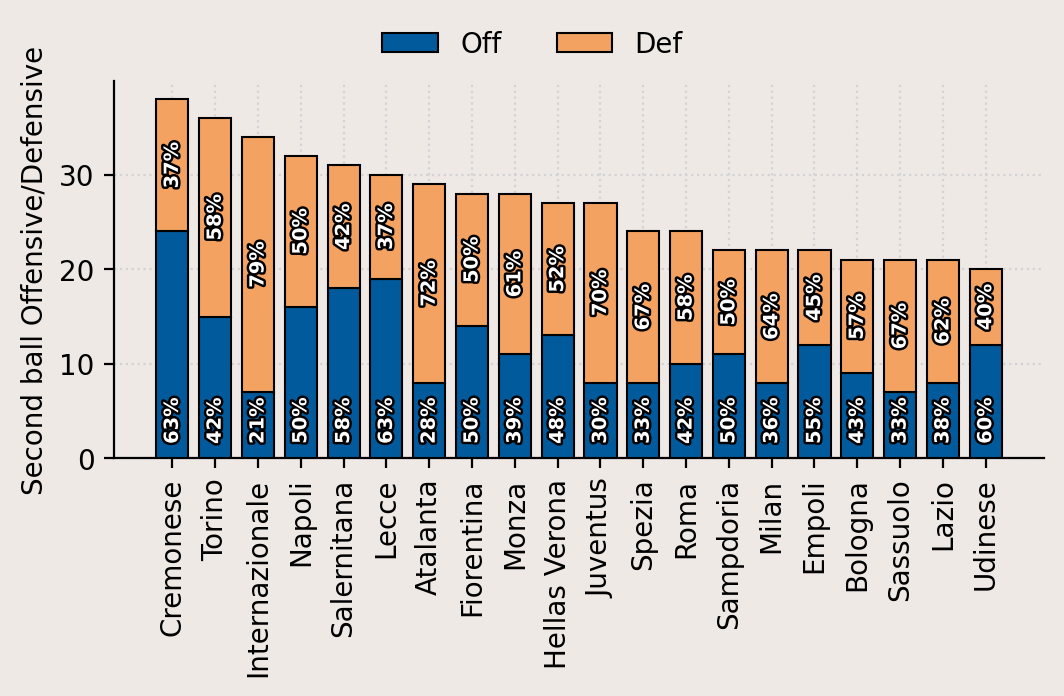

In [77]:
fig = plt.figure(figsize=(6, 2.5), dpi = 200, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")

# Add spines
ax.spines["top"].set(visible = False)
ax.spines["right"].set(visible = False)

# Add grid and axis labels
ax.grid(True, color = "lightgrey", ls = ":")
ax.set_ylabel("Second ball Offensive/Defensive")

# offensive SB
ax.bar(
    X, 
    height_o, 
    ec = "black", 
    lw = .75, 
    color = "#005a9b", 
    zorder = 3, 
    width = 0.75,
    label = "Off"
)

# defensive SB
ax.bar(
    X, 
    height_d,
    bottom = height_o, # This creates the stacked chart 
    ec = "black", 
    lw = .75, 
    color = "#f4a261", 
    zorder = 3, 
    width = 0.75,
    label = "Def"
)

ax.legend(
    ncol = 2, 
    loc = "upper center", 
    bbox_to_anchor = (0.45, 1.2),
    frameon = False
)

# Annotate the bar chart
aux_counter = 0
for y_o, y_d in zip(height_o, height_d):
    # annotate percentage of fouls in the center of the bar
    home_text = ax.annotate(
        xy = (aux_counter, y_h/2),
        text = f"{y_o/(y_o + y_d):.0%}", # F-strings are cool :)
        size = 7,
        ha = "center",
        va = "center",
        weight = "bold",
        color = "white",
        rotation = 90
    )

    away_text = ax.annotate(
        xy = (aux_counter, y_o + y_d/2), # Notice the sum of the bottom data.
        text = f"{y_d/(y_o + y_d):.0%}",
        size = 7,
        ha = "center",
        va = "center",
        weight = "bold",
        color = "white",
        rotation = 90
    )

    home_text.set_path_effects(
        [path_effects.Stroke(linewidth=1.75, foreground="black"), path_effects.Normal()]
    )

    away_text.set_path_effects(
        [path_effects.Stroke(linewidth=1.75, foreground="black"), path_effects.Normal()]
    )

    aux_counter += 1


# Adjust ticks
xticks_ = ax.xaxis.set_ticks(
    ticks = X,
    labels = sort_order,
    rotation = 90
)


# Final chart beautification
TeamId dataframe to scrape FootMob badges

In [78]:
teams = ['Fiorentina',
         'Milan',
         'Atalanta',
         'Bologna',
         'Cremonese',
         'Empoli',
         'Hellas Verona',
         'Internazionale',
         'Juventus',
         'Lazio',
         'Lecce',
         'Monza',
         'Roma',
         'Napoli',
         'Salernitana',
         'Sampdoria',
         'Sassuolo',
         'Spezia',
         'Torino',
         'Udinese',
         'Genoa',
         'Cagliari',
         'Venezia',
         'Benevento',
         'Crotone',
         'Parma',
         'Brescia',
         'Spal']

footId = [8535,
          8564,
          8524,
          9857,
          7801,
          8534,
          9876,
          8636,
          9885,
          8543,
          9888,
          6504,
          8686,
          9875,
          6480,
          9882,
          7943,
          9881,
          9804,
          8600,
          10233,
          8529,
          7881,
          6266,
          9884,
          10167,
          9858,
          8547]

footTeams = pd.DataFrame({'team': teams,
                   'footId': footId})

In [79]:
sb_2223_per_team_venue_b = pd.merge(sb_2223_per_team_venue, footTeams, how = "left")

In [80]:
sb_2223_per_team_venue_b.replace({
    "team":{
         'Fiorentina' : 'FIO',
         'Milan':'MIL',
         'Atalanta':'ATA',
         'Bologna':'BOL',
         'Cremonese':'CRE',
         'Empoli':'EMP',
         'Hellas Verona':'VER',
         'Internazionale':'INT',
         'Juventus':'JUV',
         'Lazio':'LAZ',
         'Lecce':'LEC',
         'Monza':'MON',
         'Roma':'ROM',
         'Napoli':'NAP',
         'Salernitana':'SAL',
         'Sampdoria':'SAM',
         'Sassuolo':'SAS',
         'Spezia':'SPE',
         'Torino':'TOR',
         'Udinese':'UDI',
         'Genoa':'GEN',
         'Cagliari':'CAG',
         'Venezia':'VEN',
         'Benevento':'BEN',
         'Crotone':'CRO',
         'Parma':'PAR',
         'Brescia':'BRE',
         'Spal':'SPA'
    }
}, inplace = True)

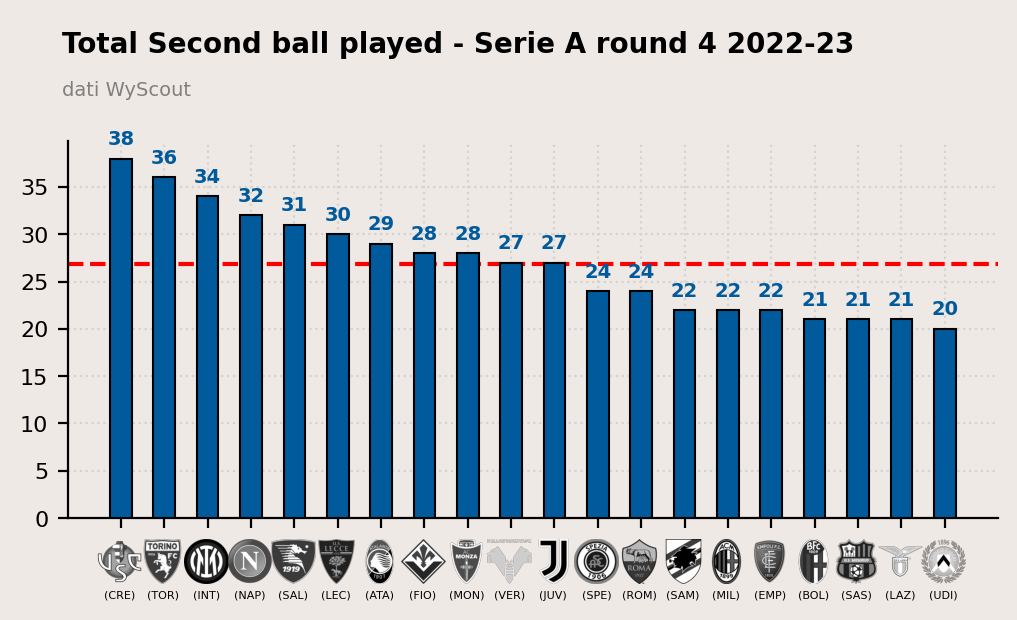

In [100]:
X_2223=sb_2223_by_team.index
height_2223 = sb_2223_by_team
sb_2223_avg = sb_2223_per_team_venue_b['total second balls'].mean()
fig = plt.figure(figsize=(6, 2.5), dpi = 200, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")

# Add spines
ax.spines["top"].set(visible = False)
ax.spines["right"].set(visible = False)

# Add grid and axis labels
ax.grid(True, color = "lightgrey", ls = ":")

# We specify the width of the bar
width = 0.5

# Second balls
ax.bar(
    X_2223, 
    height_2223,
    ec = "black", 
    lw = .75, 
    color = "#005a9b", 
    zorder = 3, 
    width = width,
    label = "Second ball"
)

ax.axhline(y=sb_2223_avg, color='red', linestyle='--', label='average')

for index, y in enumerate(height_2223):
    ax.annotate(
        xy = (index, y),
        text = f"{y:.0f}",
        xytext = (0, 7),
        textcoords = "offset points",
        size = 7,
        color = "#005a9b",
        ha = "center",
        va = "center",
        weight = "bold"
    )

xticks_ = ax.xaxis.set_ticks(
    ticks = X_2223,
    labels = []
    )

ax.tick_params(labelsize = 8)


# --- Axes transformations

DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform

# Native data to normalized data coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"
for index, team_id in enumerate(sb_2223_per_team_venue_b["footId"]):
    ax_coords = DC_to_NFC([index - 1.1*width, -7])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.09, 0.09], anchor = "W")
    club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{team_id:.0f}.png")).convert("LA")
    logo_ax.imshow(club_icon)
    logo_ax.axis("off")

    logo_ax.annotate(
        xy =(0, 0),
        text = f"({sb_2223_per_team_venue_b['team'].iloc[index]})",
        xytext = (8, -20),
        textcoords = "offset points",
        size = 4,
        ha = "center",
        va = "center"
    )

fig_text(
    x = 0.12, y = 1.1,
    s = "Total Second ball played - Serie A round 4 2022-23",
    family = "DM Sans",
    weight = "bold",
    size = 10
)
fig_text(
    x = 0.12, y = 1,
    s = "dati WyScout",
    family = "Karla",
    color = "grey",
    size = 7
)

plt.show()

Second Ball per Air Duel - Serie A 2022/23

In [33]:
# SB and Duel
sb_2223_per_team_venue, sort_order = DFpreprocessingPRO(sb_2223)
sb_2223_per_team_venue['SB/duel'] = round(sb_2223_per_team_venue['Second Ball']/sb_2223_per_team_venue['Duel'],3)
sb_2223_per_team_venue.sort_values(by='SB/duel', ascending=False, inplace=True)
sb_2223_per_team_venue.reset_index(inplace=True, drop=True)

In [34]:
sb_2223_per_team_venue_duel = pd.merge(sb_2223_per_team_venue, footTeams, how = "left")
sb_2223_per_team_venue_duel.replace({
    "team":{
         'Fiorentina' : 'FIO',
         'Milan':'MIL',
         'Atalanta':'ATA',
         'Bologna':'BOL',
         'Cremonese':'CRE',
         'Empoli':'EMP',
         'Hellas Verona':'VER',
         'Internazionale':'INT',
         'Juventus':'JUV',
         'Lazio':'LAZ',
         'Lecce':'LEC',
         'Monza':'MON',
         'Roma':'ROM',
         'Napoli':'NAP',
         'Salernitana':'SAL',
         'Sampdoria':'SAM',
         'Sassuolo':'SAS',
         'Spezia':'SPE',
         'Torino':'TOR',
         'Udinese':'UDI',
         'Genoa':'GEN',
         'Cagliari':'CAG',
         'Venezia':'VEN',
         'Benevento':'BEN',
         'Crotone':'CRO',
         'Parma':'PAR',
         'Brescia':'BRE',
         'Spal':'SPA'
    }
}, inplace = True)

In [102]:
X_2223 = sb_2223_per_team_venue_duel['team'].values
height_2223 = sb_2223_per_team_venue_duel['SB/duel'].values
sb_2223_avg = sb_2223_per_team_venue_duel['SB/duel'].mean()


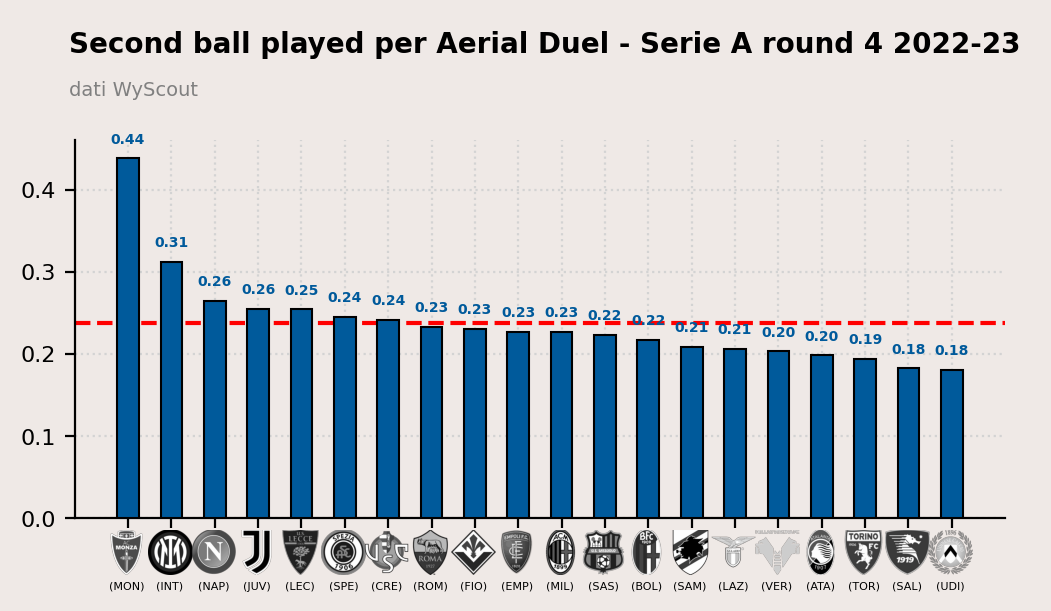

In [103]:
fig = plt.figure(figsize=(6, 2.5), dpi = 200, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")

# Add spines
ax.spines["top"].set(visible = False)
ax.spines["right"].set(visible = False)

# Add grid and axis labels
ax.grid(True, color = "lightgrey", ls = ":")

# We specify the width of the bar
width = 0.5

# Second balls
ax.bar(
    X_2223, 
    height_2223,
    ec = "black", 
    lw = .75, 
    color = "#005a9b", 
    zorder = 3, 
    width = width,
    label = "Second ball"
)

ax.axhline(y=sb_2223_avg, color='red', linestyle='--', label='average')

for index, y in enumerate(height_2223):
    ax.annotate(
        xy = (index, y),
        text = f"{y:.2f}",
        xytext = (0, 7),
        textcoords = "offset points",
        size = 5,
        color = "#005a9b",
        ha = "center",
        va = "center",
        weight = "bold"
    )

xticks_ = ax.xaxis.set_ticks(
    ticks = X_2223,
    labels = []
    )

ax.tick_params(labelsize = 8)


# --- Axes transformations

DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform

# Native data to normalized data coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"
for index, team_id in enumerate(sb_2223_per_team_venue_duel["footId"]):
    ax_coords = DC_to_NFC([index - 1.1*width, -0.07])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.09, 0.09], anchor = "W")
    club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{team_id:.0f}.png")).convert("LA")
    logo_ax.imshow(club_icon)
    logo_ax.axis("off")

    logo_ax.annotate(
        xy =(0, 0),
        text = f"({sb_2223_per_team_venue_duel['team'].iloc[index]})",
        xytext = (8, -20),
        textcoords = "offset points",
        size = 4,
        ha = "center",
        va = "center"
    )

fig_text(
    x = 0.12, y = 1.1,
    s = "Second ball played per Aerial Duel - Serie A round 4 2022-23",
    family = "DM Sans",
    weight = "bold",
    size = 10
)
fig_text(
    x = 0.12, y = 1,
    s = "dati WyScout",
    family = "Karla",
    color = "grey",
    size = 7
)
plt.show()

# Cremonese 2022-23 (round 4): detailed analysis

In [54]:
sb_2223_cremo = sb_2223[(sb_2223.team == "Cremonese") & (sb_2223.eventName == "Second Ball")]

Overall Cremonese SB pitch distribution

In [38]:
img = Image.open('../src/pitch1.png')
# Define the measure of the pitch
pitch = {'x' : 135,
         'y' : 95}

# Pitch image as backgound
background_image = dict(
            source=img,
            xref="x",
            yref="y",
            x=0,
            y=0,
            sizex=pitch['x'],
            sizey=pitch['y'],
            sizing="stretch",
            opacity=0.8,
            layer="below")

rangex=[0,135]
rangey=[95,0]
ww=1163 #image width
hh=783 # image height


In [55]:
df=sb_2223_cremo
df['x'] = df['x'].apply(lambda x : (x * pitch['x'])/100)
df['y'] = df['y'].apply(lambda x : (x * pitch['y'])/100)


fig = px.scatter(df, x='x',y='y', range_x=rangex, range_y=rangey, width=ww/1.5, height=hh/1.5,
                    marginal_x = 'histogram',marginal_y = 'histogram', opacity = 0.8, hover_data=['match', 'player'])
fig.add_layout_image(background_image)
fig.update_layout(dict(
                  width=ww/1.5, height=hh/1.5, 
                  xaxis =  {'showgrid': False},
                  yaxis = {'showgrid': False},
                  yaxis_range= rangey,
                  xaxis_range = rangex
                  )
                 )
fig.update_layout(title_text = '2022-23 Cremonese SB played',
                  title_font_family = 'Karla',
                  title_font_size = 20
                 )


C:\Users\fgron\AppData\Local\Temp\ipykernel_30472\2459334675.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\fgron\AppData\Local\Temp\ipykernel_30472\2459334675.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

